# 7章 RNNによる文章生成

5章、6章で扱ったRNN、LSTMを利用してアプリケーションを実装

言語モデルを使った「文章生成」と新しいニューラルネットワークである「seq2seq」を扱う

## 7.1 言語モデルを使った文章生成

### 7.1.1 RNNによる文章生成の手順

「you say goodbye and I say hello.」というコーパスで学習を行った言語モデルを考え、「I」という単語を与えて、「say」が出力される場合を考える

言語モデルはこれまでに与えられた単語から、次に出現する単語の確率分布を出力する

ここで、生成される文章が毎回変動するようにする(確率的)

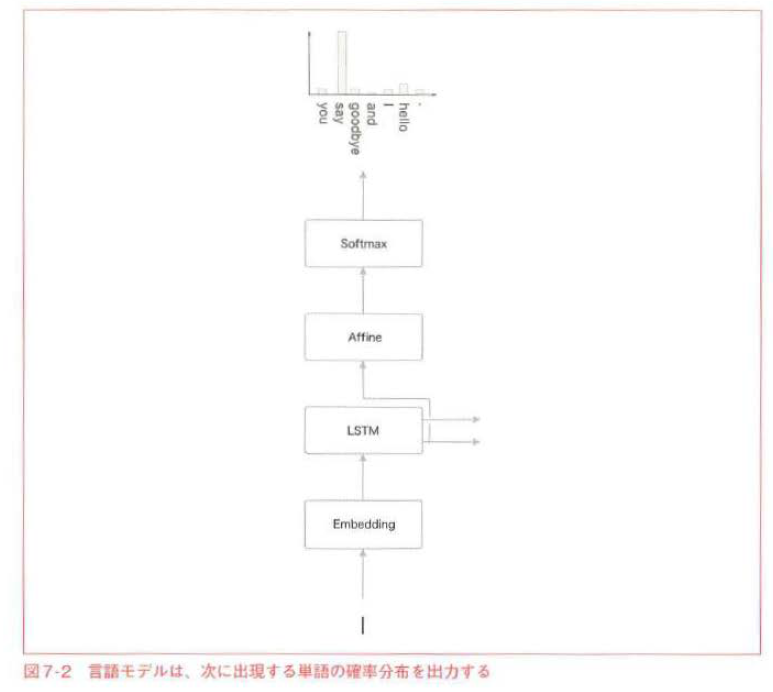

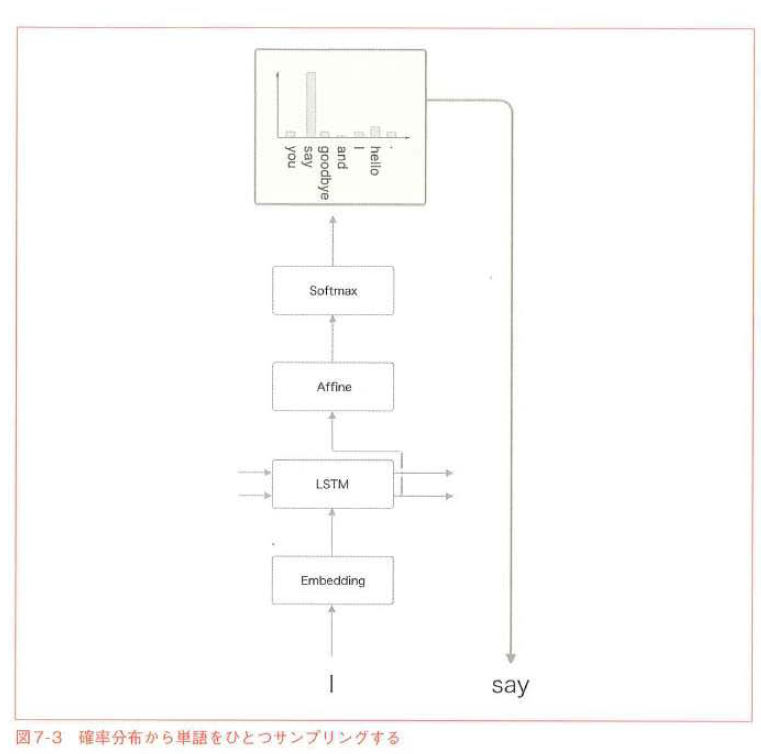

次に、2つめの単語のサンプリングを行う  
先ほど生成した「say」を言語モデルに入力して、次に来る単語の確率分布を調べる

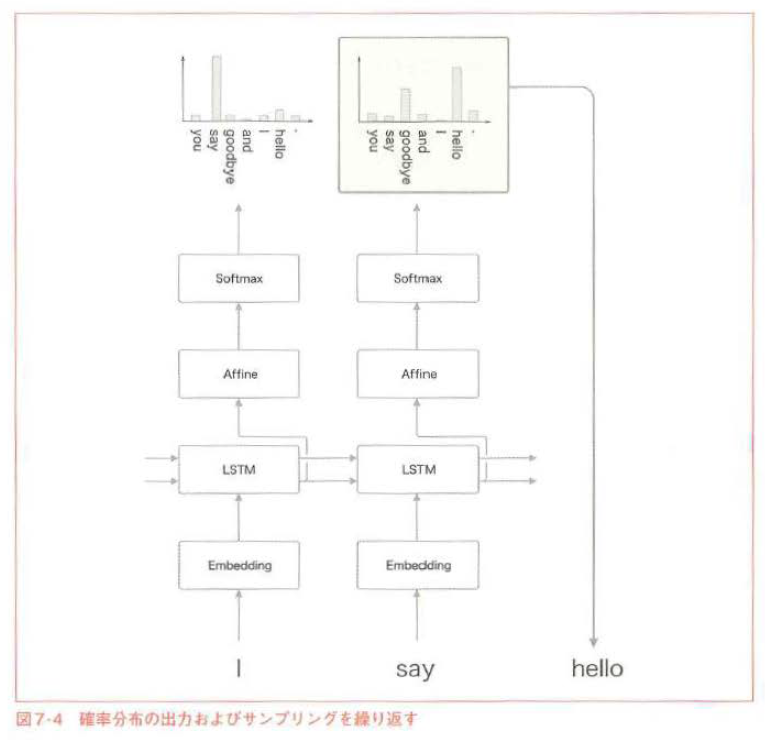

これを望む回数、もしくは文末記号が出るまで繰り返す

### 7.1.2 文章生成の実装

前章の「Rnnlmクラス」をベースに「RnnlmGenクラス」を作成する

#### クラスの継承  
既存のクラスを引き継ぎ、新しいクラスを作る

Baseクラスを継承して新たにNewクラスを作るとき  
#### class New(Base)  
と書く

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

#### generate(start_id, skip_ids, sample_size)
を用いて文章を生成する

・start_id...最初に与える単語ID  
・skip_ids...単語IDのリストを想定し、指定された単語IDがサンプリングされないようにする  
・sample_size...サンプリングする単語の数

また、generate()のメソッドの中身は

・model.predict(x)...各単語の正規化される前のスコアを出力  
・p = softmax(score)...スコアを正規化  
・np.random.choice()...確率分布からのサンプリング

RnnlmGenクラスを用いて文章生成

In [2]:
import sys
sys.path.append('..')
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch06/Rnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you turns away between its major competitor.
 we want an experiment cynthia by release a white knight opposed and to japan 's price-earnings economic chains.
 but their debut are experiencing strong he would popular overseas requirements by now.
 for bernstein enterprises prosecutors had asked management engaged in british judge mr. sorrell with necessity acquired banco losses of consumer information sales damaged a month.
 the five-year plan would continue to be disciplined only about millions of warsaw diplomat.
 but many people issued that someone probably was abandoned.
 we would promises have substantial secret.
 david


モデルの重みがランダムな初期値のため、でたらめな文章が出力される

前章では、より良い言語モデルをBetterRnnlmクラスとして実装した

この言語モデルに先頭文字「you」を与えてみる

In [3]:
import sys
sys.path.append('..')
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('../ch06/BetterRnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)

you think it those a concerned we suggest about that it would become longer to put a invitation of monday in cases because of overall contracts four.
 mr. roman concedes a massachusetts pesetas at least hours frustration indexing corp..
 increasing it in a colony with particular gave that appear to country between its applications to serve a meeting it does n't always longer say can banned a resign reserved with french animals.
 alone protests on no angels money that has had been financially in toilet exceeding as an service unit on plant prospect tire 's basis to


先ほどよりもやや自然な文章に

['the', 'meaning', 'of', 'life']という単語をモデルに与えて順伝播

「is」を先頭文字とすることで「the meaning of life is」に続く文章を生成できる

In [4]:
model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
the meaning of life is very large summit on a future business observers has import the new housing high and give that seek those says program loans later and investors will be sought to acquire the future is heavily treaty to 'm a subsidies adult.
 at stocks traders ruling bankruptcy stated anger and it is to bono agree with mr. honecker is n't see it about ending summer in technology in boston an number of details of register marketplace costs.
 ultimately disk-drive.
 premises damage on u.s. companies were workstations in bill because of there are i think so there is no


## 7.2 seq2seq

2つのRNNを使う「seq2seq」(sequence to sequence)は

時系列データを別の時系列データに変換できる

### 7.2.1 seq2seqの原理

別名「Encoder-Decoderモデル」

・Encoder...入力データをエンコードする

・Decoder...エンコードされたデータをデコードする

・エンコード...符号化。情報をある規則に基づいて変換すること

例)「A」→「1000001(２進数)」

### seq2seqの具体例

日本語を英語に翻訳

Encoderに日本語を入力

Decoderに渡され、英語に変換して出力

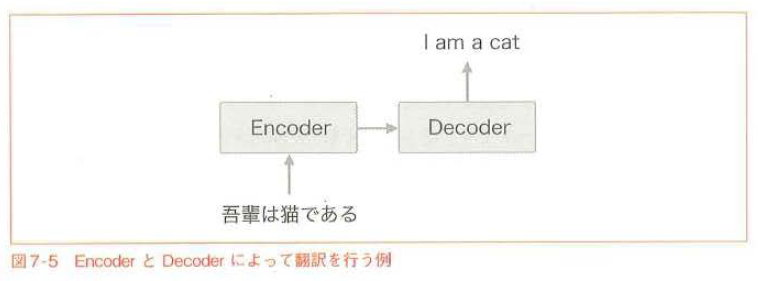

EncoderはRNN(LSTM)を利用して、時系列データを「h」という隠れ状態ベクトルに変換して出力

エンコードするとは、任意の長さのベクトルを固定長のベクトルに変換すること

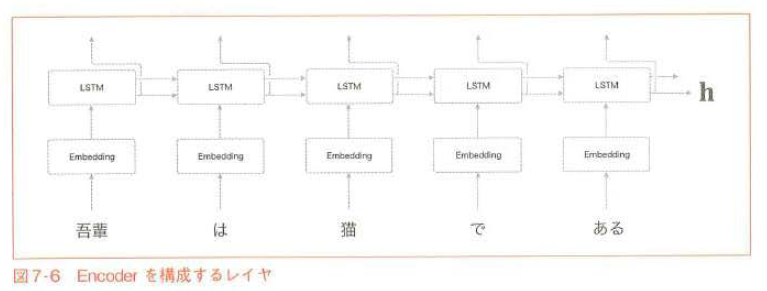

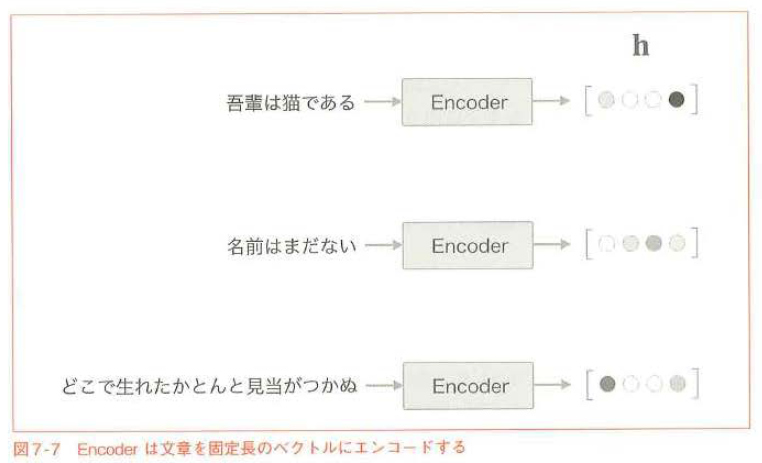

Decoderは7.1節のニューラルネットワークに一致

ただし、LSTMレイヤが隠れ状態「h」を受け取るようになる

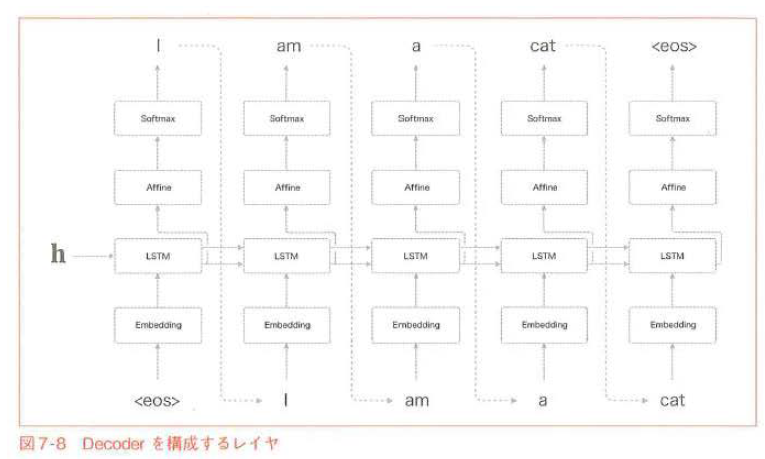

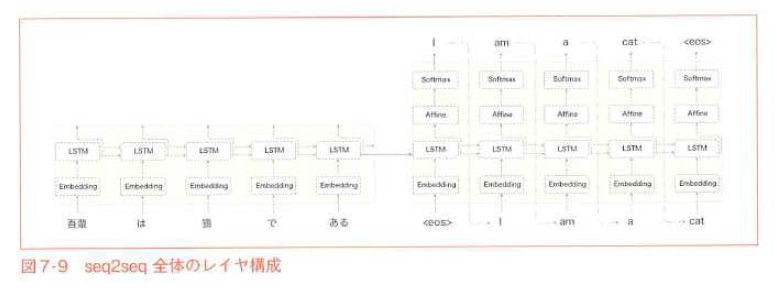

### 7.2.2 時系列データ変換用のトイ・プロブレム

ここからseq2seqを実装

トイ・プロブレム...機械学習を評価するために作られた簡単な問題

今回は足し算を使用

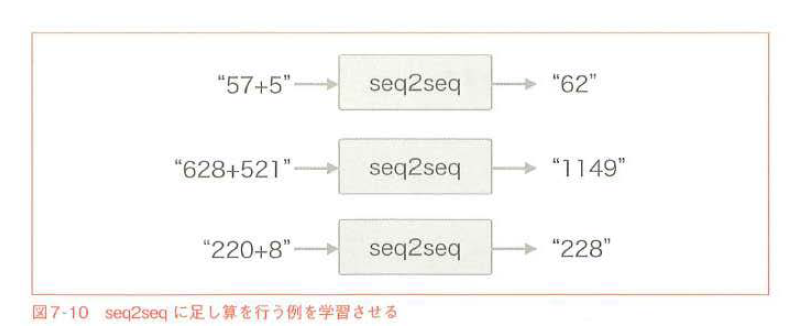

### 7.2.3 可変長の時系列データ

足し算の場合、問題ごとに文字数が異なる

パディング...本来のデータを無効なデータ(空白文字)で埋め、データの長さを統一する

今回の問題では0～999の２つの数の足し算を行う

さらに、Decoderに文字列生成を知らせる合図として、「_ （アンダースコア）」を先頭に付け区切り文字とする

ただし、パディング専用の処理が必要

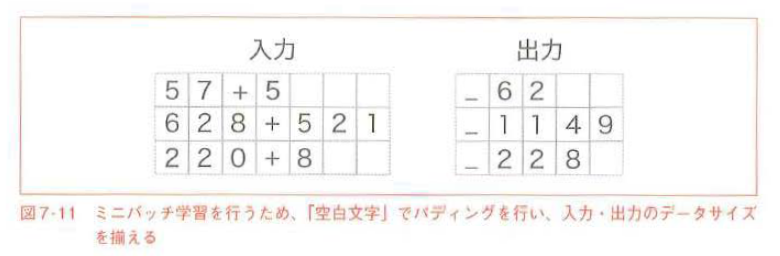

### 7.2.4 足し算データセット

50,000個の学習データを処理する

・load_data(file_name, seed)...指定されたテキストファイルを読み込み、テキストを文字IDに変換し、それを訓練データとテストデータに分けて返す

・get_vacab()...文字とIDの対応関係を表すディクショナリを返す

In [6]:
import sys
import numpy as np
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 7.3 seq2seqの実装

EncoderとDecoderを組み合わせてseq2seqを作る

### 7.3 1 Encoderクラス

入力の文字列を、ベクトル「h」へ変換

・Embeddingレイヤ...文字(ID)を文字ベクトルへ変換

・LSTMレイヤ...時間方向に隠れ状態とセルを、上方向には隠れ状態のみを出力

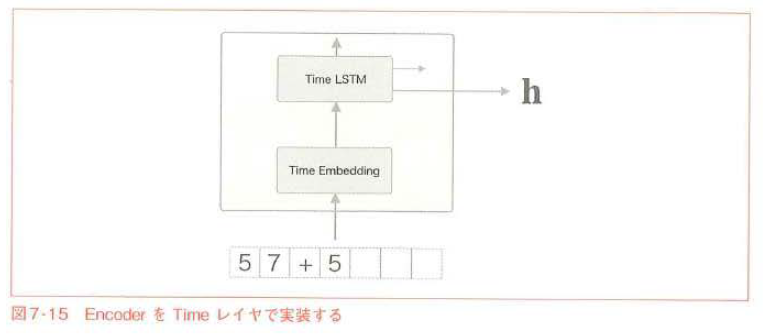

Encoderクラスを実装
初期化、順伝播、逆伝播の__int__()、forward()、backward()の３つのメソッドに分けられる

初期化ではvocab_size、wordvec_size、hidden_sizeの３つの引数を受け取る

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

順伝播と逆伝播

In [8]:
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 7.3.2 Decoderクラス

LSTMレイヤを使う

今回はSoftmaxレイヤを使わずに、Affineレイヤの出力するスコアを対象に「argmax」ノードで選ぶ

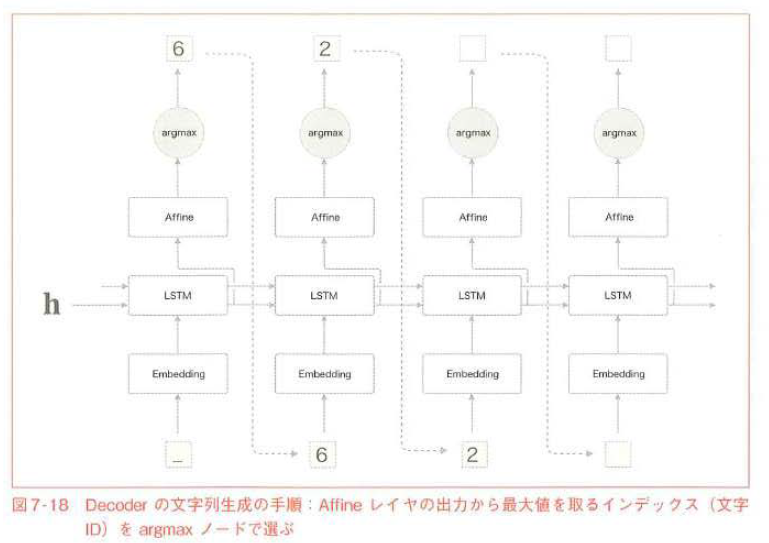

TimeEmbedding、TimeLSTM、TimeAffineからなる

In [9]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

### 7.3.3 seq2seqクラス

最後にseq2seqの実装

In [10]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 7.3.4 seq2seqの評価

基本的なニューラルネットワークの学習とは
１、学習データからミニバッチを選び
２、ミニバッチから勾配を計算し
３、勾配を使ってパラメータを更新する

In [11]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 4[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 5[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 5[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 7[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 8[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 8[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 9[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 10[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 11[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 11[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 12[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 


| epoch 7 |  iter 121 / 351 | time 5[s] | loss 1.09
| epoch 7 |  iter 141 / 351 | time 6[s] | loss 1.07
| epoch 7 |  iter 161 / 351 | time 6[s] | loss 1.08
| epoch 7 |  iter 181 / 351 | time 7[s] | loss 1.08
| epoch 7 |  iter 201 / 351 | time 8[s] | loss 1.07
| epoch 7 |  iter 221 / 351 | time 9[s] | loss 1.06
| epoch 7 |  iter 241 / 351 | time 10[s] | loss 1.07
| epoch 7 |  iter 261 / 351 | time 11[s] | loss 1.07
| epoch 7 |  iter 281 / 351 | time 11[s] | loss 1.06
| epoch 7 |  iter 301 / 351 | time 12[s] | loss 1.07
| epoch 7 |  iter 321 / 351 | time 13[s] | loss 1.09
| epoch 7 |  iter 341 / 351 | time 14[s] | loss 1.06
Q 77+85  
T 162 
☒ 156 
---
Q 975+164
T 1139
☒ 1166
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 148 
---
Q 367+55 
T 422 
☒ 412 
---
Q 600+257
T 857 
☒ 892 
---
Q 761+292
T 1053
☒ 1056
---
Q 830+597
T 1427
☒ 1409
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 227 
---
val acc 3.820%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 1.05
| epoch 8 |  iter 21 / 35

| epoch 13 |  iter 221 / 351 | time 8[s] | loss 0.90
| epoch 13 |  iter 241 / 351 | time 9[s] | loss 0.88
| epoch 13 |  iter 261 / 351 | time 9[s] | loss 0.90
| epoch 13 |  iter 281 / 351 | time 10[s] | loss 0.91
| epoch 13 |  iter 301 / 351 | time 11[s] | loss 0.88
| epoch 13 |  iter 321 / 351 | time 11[s] | loss 0.89
| epoch 13 |  iter 341 / 351 | time 12[s] | loss 0.89
Q 77+85  
T 162 
☒ 164 
---
Q 975+164
T 1139
☒ 1161
---
Q 582+84 
T 666 
☒ 669 
---
Q 8+155  
T 163 
☒ 167 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 859 
---
Q 761+292
T 1053
☒ 1049
---
Q 830+597
T 1427
☒ 1441
---
Q 26+838 
T 864 
☒ 869 
---
Q 143+93 
T 236 
☒ 239 
---
val acc 6.700%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.91
| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.90
| epoch 14 |  iter 41 / 351 | time 1[s] | loss 0.89
| epoch 14 |  iter 61 / 351 | time 2[s] | loss 0.88
| epoch 14 |  iter 81 / 351 | time 3[s] | loss 0.89
| epoch 14 |  iter 101 / 351 | time 3[s] | loss 0.88
| epoch 14 |  iter

| epoch 19 |  iter 301 / 351 | time 11[s] | loss 0.86
| epoch 19 |  iter 321 / 351 | time 12[s] | loss 0.85
| epoch 19 |  iter 341 / 351 | time 13[s] | loss 0.85
Q 77+85  
T 162 
☒ 164 
---
Q 975+164
T 1139
☒ 1162
---
Q 582+84 
T 666 
☒ 672 
---
Q 8+155  
T 163 
☒ 167 
---
Q 367+55 
T 422 
☒ 427 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☒ 1049
---
Q 830+597
T 1427
☒ 1424
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 237 
---
val acc 8.680%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.81
| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.83
| epoch 20 |  iter 41 / 351 | time 1[s] | loss 0.84
| epoch 20 |  iter 61 / 351 | time 2[s] | loss 0.83
| epoch 20 |  iter 81 / 351 | time 3[s] | loss 0.84
| epoch 20 |  iter 101 / 351 | time 3[s] | loss 0.83
| epoch 20 |  iter 121 / 351 | time 4[s] | loss 0.84
| epoch 20 |  iter 141 / 351 | time 5[s] | loss 0.83
| epoch 20 |  iter 161 / 351 | time 6[s] | loss 0.84
| epoch 20 |  iter 181 / 351 | time 6[s] | loss 0.84
| epoch 20 |  iter 

val acc 10.380%


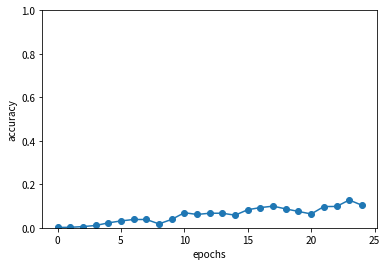

In [12]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

回数を重ねると正答率が上昇する

### 7.4 seq2seqの改良

学習の進みを改善

### 7.4.1 入力データの反転(Reverse)

多くの場合学習の進みが速くなり、最終的な精度も良くなる

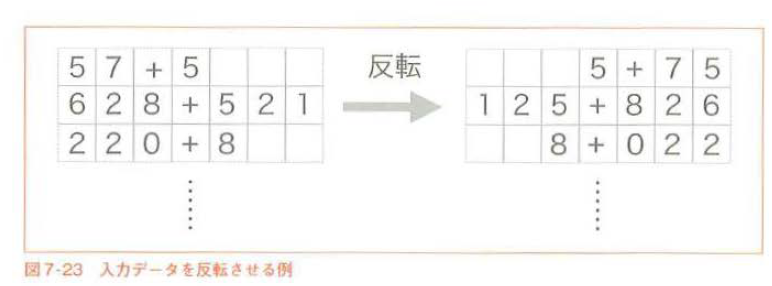

### 7.4.2 覗き見(Peeky)

Decoderの最初のLSTMしか受け取らない隠れ状態「h」を活用

全ての時刻のAffineレイヤとLSTMレイヤに与える

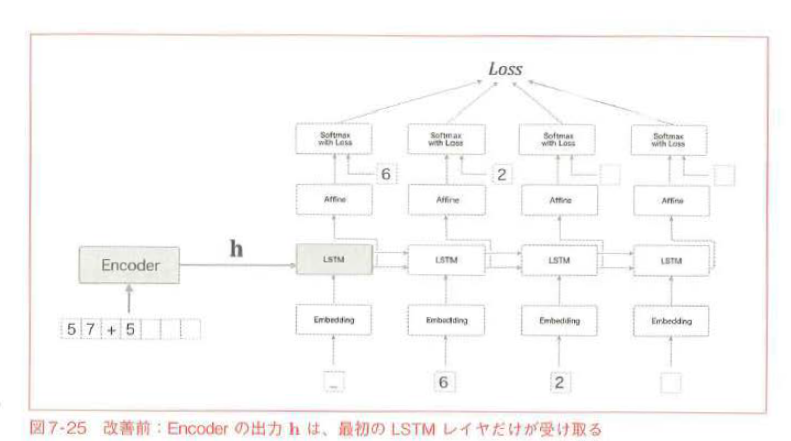

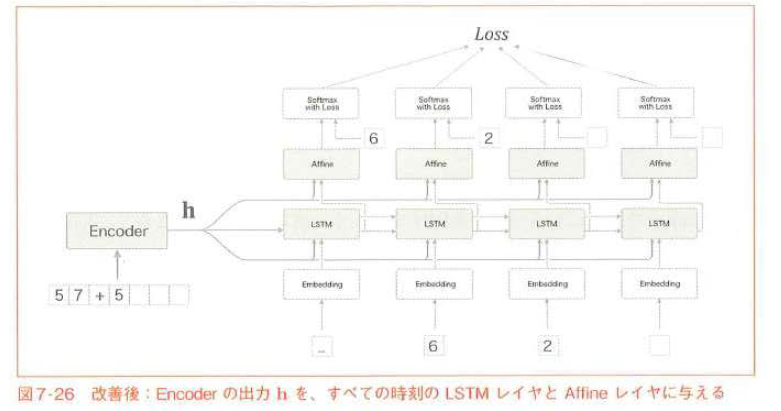

PeekyDecoderクラスの実装

In [13]:
import sys
sys.path.append('..')
from common.time_layers import *
from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

In [14]:
from seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 4[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 5[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 6[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 6[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 7[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 8[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 9[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 10[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 11[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 12[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 13[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 14[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 14[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84

| epoch 7 |  iter 121 / 351 | time 5[s] | loss 0.65
| epoch 7 |  iter 141 / 351 | time 5[s] | loss 0.64
| epoch 7 |  iter 161 / 351 | time 6[s] | loss 0.63
| epoch 7 |  iter 181 / 351 | time 7[s] | loss 0.61
| epoch 7 |  iter 201 / 351 | time 8[s] | loss 0.61
| epoch 7 |  iter 221 / 351 | time 9[s] | loss 0.60
| epoch 7 |  iter 241 / 351 | time 10[s] | loss 0.57
| epoch 7 |  iter 261 / 351 | time 11[s] | loss 0.57
| epoch 7 |  iter 281 / 351 | time 12[s] | loss 0.57
| epoch 7 |  iter 301 / 351 | time 12[s] | loss 0.55
| epoch 7 |  iter 321 / 351 | time 13[s] | loss 0.54
| epoch 7 |  iter 341 / 351 | time 14[s] | loss 0.53
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 156 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 858 
---
Q 761+292
T 1053
☒ 1052
---
Q 830+597
T 1427
☒ 1428
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 235 
---
val acc 39.100%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.51
| epoch 8 |  iter 21 / 3

| epoch 13 |  iter 201 / 351 | time 9[s] | loss 0.06
| epoch 13 |  iter 221 / 351 | time 10[s] | loss 0.06
| epoch 13 |  iter 241 / 351 | time 11[s] | loss 0.06
| epoch 13 |  iter 261 / 351 | time 12[s] | loss 0.06
| epoch 13 |  iter 281 / 351 | time 13[s] | loss 0.06
| epoch 13 |  iter 301 / 351 | time 14[s] | loss 0.05
| epoch 13 |  iter 321 / 351 | time 14[s] | loss 0.05
| epoch 13 |  iter 341 / 351 | time 15[s] | loss 0.06
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
val acc 94.380%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.05
| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.05
| epoch 14 |  iter 41 / 351 | time 1[s] | loss 0.05
| epoch 14 |  iter 61 / 351 | time 2[s] | loss 0.05
| epoch 14 |  iter 81 / 351 | time 3[s] | loss 0.05
| epoch 14 |  

| epoch 19 |  iter 261 / 351 | time 11[s] | loss 0.02
| epoch 19 |  iter 281 / 351 | time 12[s] | loss 0.02
| epoch 19 |  iter 301 / 351 | time 12[s] | loss 0.02
| epoch 19 |  iter 321 / 351 | time 13[s] | loss 0.02
| epoch 19 |  iter 341 / 351 | time 14[s] | loss 0.02
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
val acc 98.260%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.01
| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.02
| epoch 20 |  iter 41 / 351 | time 1[s] | loss 0.01
| epoch 20 |  iter 61 / 351 | time 2[s] | loss 0.01
| epoch 20 |  iter 81 / 351 | time 3[s] | loss 0.02
| epoch 20 |  iter 101 / 351 | time 4[s] | loss 0.02
| epoch 20 |  iter 121 / 351 | time 5[s] | loss 0.02
| epoch 20 |  iter 141 / 351 | time 5[s] | loss 0.02
| epoch 20 |  it

| epoch 25 |  iter 321 / 351 | time 15[s] | loss 0.01
| epoch 25 |  iter 341 / 351 | time 16[s] | loss 0.01
Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
val acc 98.800%


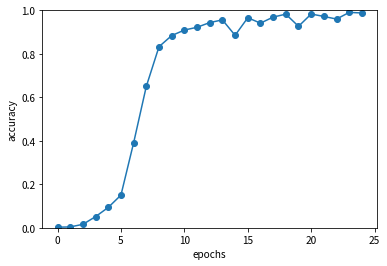

In [16]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
#model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))
    
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

反転と覗き見の改良を加えると精度が格段に上がる

### 7.5 seq2seqを用いたアプリケーション

<font color="red">seq2seqは「ある時系列データ」を「別の時系列データ」に変換</font>

・機械翻訳：「ある言語の文章」を「別の言語の文章」に変換する　　
・自動要約：「ある長い文章」を「短い要約された文章」に変換する　　
・質疑応答：「質問」を「答え」に変換する  
・メールの自動返信：「受け取ったメールの文章」を「返信文」に変換

など、対になった時系列データを扱うことができる

### 7.5.1 チャットボット

「相手の発言」を「自分の発言」に変換

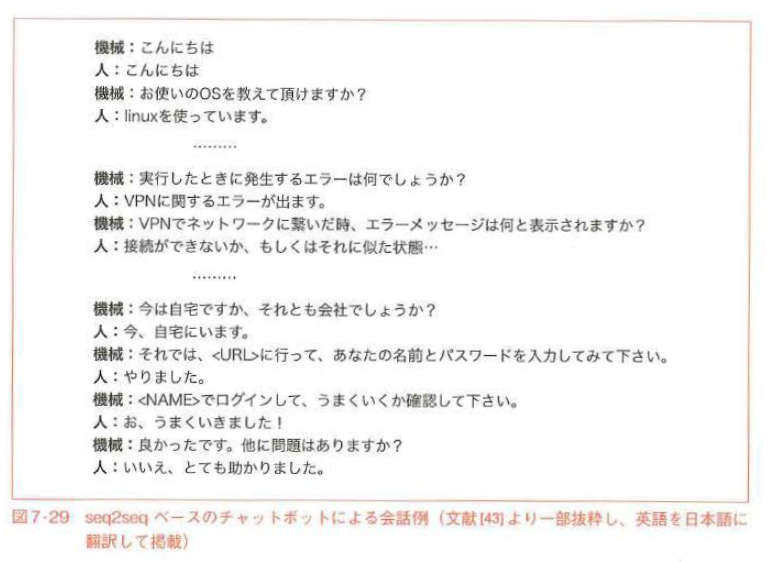

### 7.5.2 アルゴリズムの学習

ソースコードも時系列データ

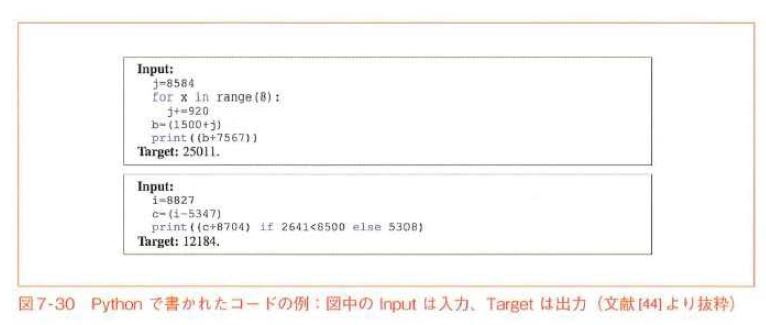

### 7.5.3 イメージキャプション

seq2seqはテキスト以外にも、画像や音声のデータも扱える

イメージキャプションは「画像」を「文章」に変換

EncoderをLSTMからCNNに変換

CNNは画像のエンコードを３次元のボリューム(高さ・幅・チャンネル)である「特徴マップ」を出力

それを１次元の特徴マップにして、全結合のAffineレイヤによって変換する

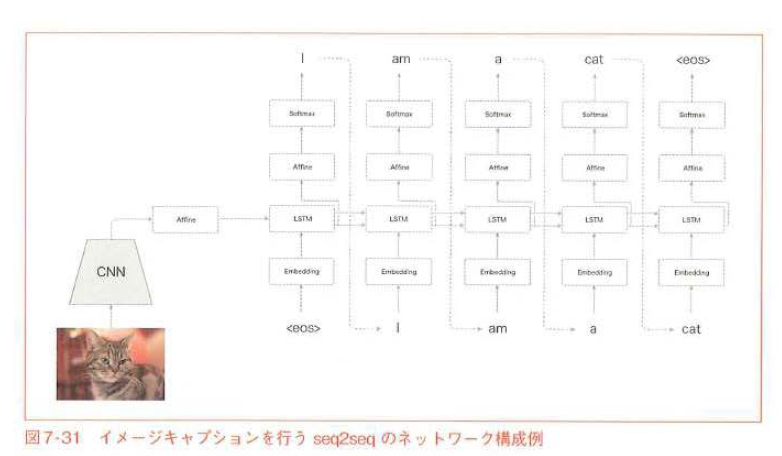

TensorFlowの実装コードのim2txtで生成された例

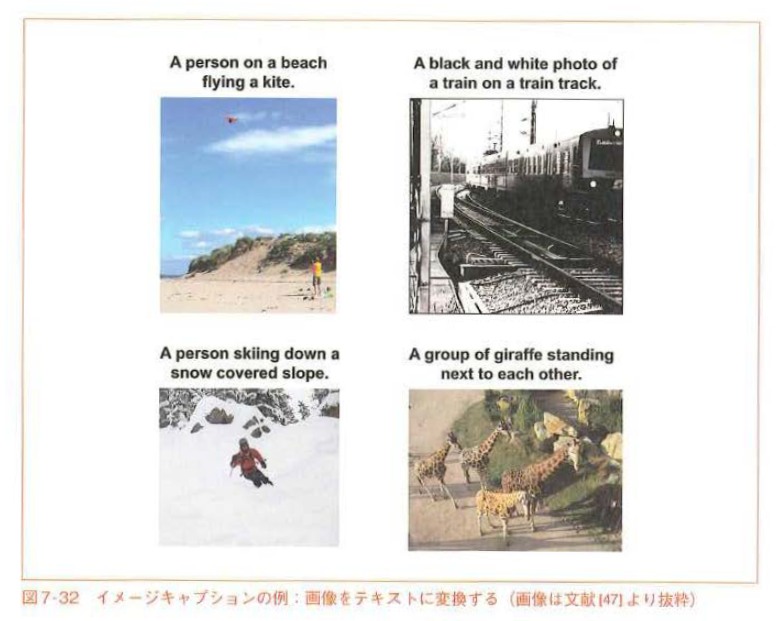

## 7.6 まとめ

・RNNを用いた言語モデルは新しい文章を生成することができる

・文章生成を行う際には、ひとつの単語(文字)を与え、モデルの出力(確率分布)からサンプリングするという手順を繰り返し行う 

・RNNを２つ組み合わせることで、時系列データを別の時系列データに変換することができる(seq2seq)  

・seq2seqは、Encoderが入力文をエンコードし、そのエンコード情報をDecoderが受け取り、デコードして目的の出力文を得る 

・入力文を反転させること(Reverse)、またエンコード情報をDecoderの複数レイヤに与えること(Peeky)は、seq2seqの精度向上に友好である  

・機械翻訳やチャットボット、イメージキャプションなど、seq2seqはさまざまなアプリケーションに利用できる